# Hourly temperature forecasting (Porto): SARIMA, baselines, SARIMAX, and ML

This notebook models hourly air temperature using classical seasonal time-series methods and compares them against simple benchmarks and a lightweight machine-learning baseline. The focus is on short-horizon forecasting (24–336 hours), where these models are typically most useful.


In [1]:
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Statsmodels
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox

# Sklearn
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit

# Plot defaults
plt.rcParams.update({
    "figure.figsize": (12, 4.5),
    "axes.grid": True,
    "grid.alpha": 0.25,
    "axes.titlesize": 13,
    "axes.labelsize": 11,
    "legend.frameon": False,
})

After parsing and indexing the timestamps, we enforce an hourly frequency to keep a regular time grid, which is required for SARIMA/SARIMAX. We also check missingness and duplicates to confirm that the series can be modeled without additional imputation.


In [2]:
DATA_PATH = Path("porto_weather_air_quality_5y.csv")

def load_data(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    df["time"] = pd.to_datetime(df["time"])
    df = df.sort_values("time").set_index("time")

    # Regular hourly grid (important for ARIMA-family models)
    
    df = df.asfreq("h")

    return df

df = load_data(DATA_PATH)
print("Shape:", df.shape)
display(df.head())
display(df.tail())

Shape: (43848, 30)


,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,pressure_msl,surface_pressure,precipitation,rain,snowfall,cloud_cover,...,pm10,pm2_5,carbon_monoxide,nitrogen_dioxide,sulphur_dioxide,ozone,aerosol_optical_depth,dust,uv_index,uv_index_clear_sky
time,,,,,,,,,,,,,,,,,,,,,
2020-11-20 00:00:00,14.0,81,10.8,12.7,1031.6,1020.9,0.0,0.0,0.0,59,...,30.7,19.2,147.0,23.7,1.8,25.0,NaN,6.0,NaN,NaN
2020-11-20 01:00:00,15.3,75,10.8,13.3,1031.0,1020.3,0.0,0.0,0.0,0,...,30.5,18.2,138.0,21.6,1.8,24.0,NaN,4.0,NaN,NaN
2020-11-20 02:00:00,15.9,72,10.9,13.1,1030.6,1019.9,0.0,0.0,0.0,0,...,26.1,15.9,134.0,14.0,1.9,27.0,NaN,5.0,NaN,NaN
2020-11-20 03:00:00,15.4,74,10.8,12.3,1030.4,1019.7,0.0,0.0,0.0,0,...,25.5,13.4,141.0,14.7,1.8,27.0,NaN,3.0,NaN,NaN
2020-11-20 04:00:00,14.6,76,10.4,11.2,1029.9,1019.2,0.0,0.0,0.0,0,...,24.2,12.8,137.0,12.5,1.8,30.0,NaN,2.0,NaN,NaN


,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,pressure_msl,surface_pressure,precipitation,rain,snowfall,cloud_cover,...,pm10,pm2_5,carbon_monoxide,nitrogen_dioxide,sulphur_dioxide,ozone,aerosol_optical_depth,dust,uv_index,uv_index_clear_sky
time,,,,,,,,,,,,,,,,,,,,,
2025-11-20 19:00:00,9.9,65,3.6,6.3,1024.7,1013.9,0.0,0.0,0.0,13,...,14.3,12.1,192.0,21.7,2.0,59.0,0.03,0.0,0.0,0.0
2025-11-20 20:00:00,9.1,68,3.6,5.9,1025.2,1014.4,0.0,0.0,0.0,100,...,16.3,12.1,194.0,24.9,2.0,56.0,0.03,0.0,0.0,0.0
2025-11-20 21:00:00,8.6,72,3.8,5.5,1025.7,1014.8,0.0,0.0,0.0,32,...,18.1,13.3,199.0,21.2,2.1,55.0,0.03,0.0,0.0,0.0
2025-11-20 22:00:00,8.1,75,3.9,5.2,1026.1,1015.2,0.0,0.0,0.0,12,...,19.3,14.2,196.0,18.9,2.1,54.0,0.03,0.0,0.0,0.0
2025-11-20 23:00:00,7.6,78,3.9,4.8,1026.5,1015.6,0.0,0.0,0.0,5,...,20.5,15.5,195.0,19.1,2.0,54.0,0.03,0.0,0.0,0.0


In [3]:
missing = df.isna().sum().sort_values(ascending=False)
print("Missing values (top 12):")
display(missing.head(12).to_frame("missing_count"))

dup = df.index.duplicated().sum()
print("Duplicated timestamps:", dup)

print("Inferred frequency:", pd.infer_freq(df.index))

Missing values (top 12):


,missing_count
wind_direction_80m,43848
wind_speed_80m,43848
uv_index,14928
uv_index_clear_sky,14928
aerosol_optical_depth,14928
temperature_2m,0
precipitation,0
rain,0
snowfall,0
relative_humidity_2m,0


Duplicated timestamps: 0
Inferred frequency: h


No duplicated timestamps were found. After enforcing a regular hourly frequency using asfreq("h"), no missing values were introduced in the target variable (temperature_2m). Therefore, no imputation or removal of observations is required before modeling.

## Simple Exploratory analysis

We start by visualizing the target series at two scales: the full multi-year history (downsampled to daily means for readability) and a short 14-day window to expose the diurnal cycle. We also inspect the marginal distribution to check for obvious outliers.


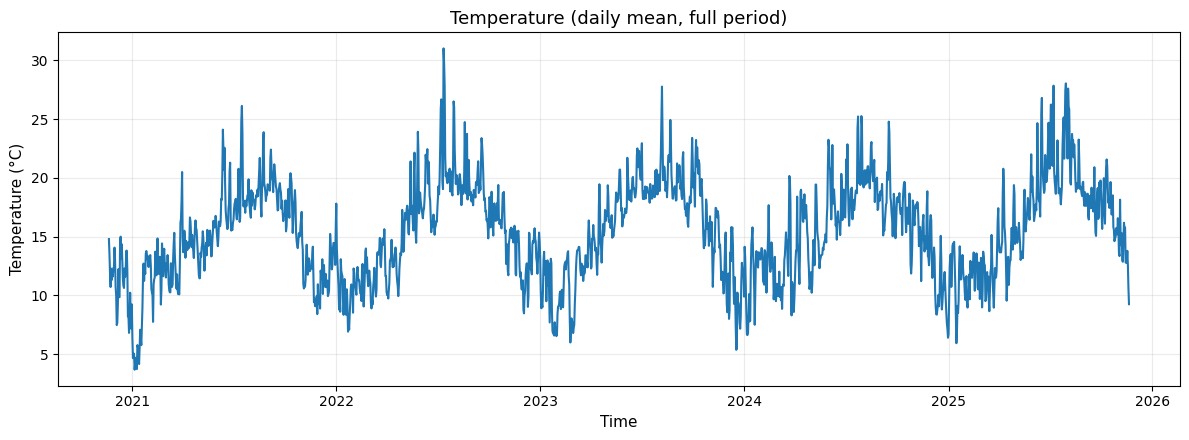

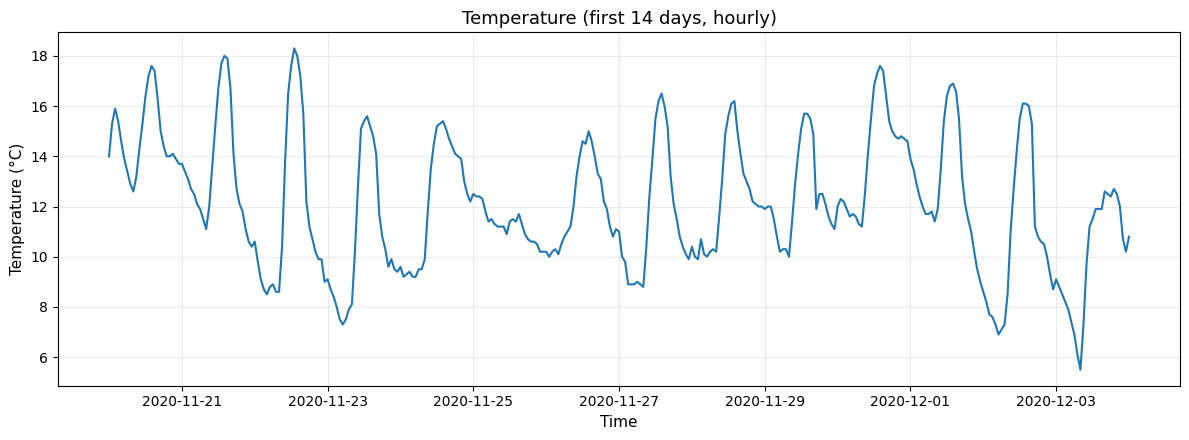

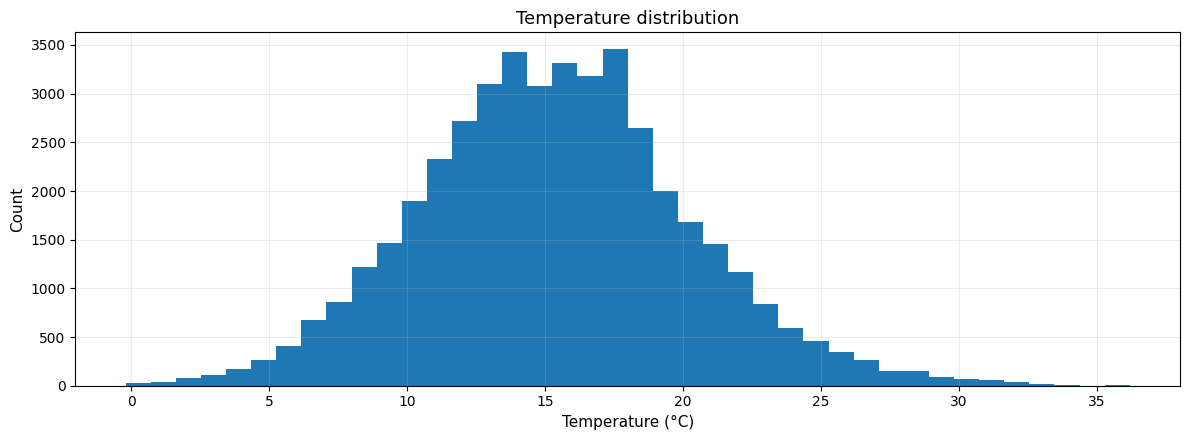

In [4]:
y = df["temperature_2m"].astype(float)

def plot_full_and_zoom(y: pd.Series, zoom_days: int = 14) -> None:
    # Full view (daily mean to avoid overplotting)
    y_daily = y.resample("D").mean()

    plt.figure()
    plt.plot(y_daily)
    plt.title("Temperature (daily mean, full period)")
    plt.xlabel("Time")
    plt.ylabel("Temperature (°C)")
    plt.tight_layout()
    plt.show()

    # Zoomed view (hourly)
    start = y.index.min()
    end = start + pd.Timedelta(days=zoom_days)

    plt.figure()
    plt.plot(y.loc[start:end])
    plt.title(f"Temperature (first {zoom_days} days, hourly)")
    plt.xlabel("Time")
    plt.ylabel("Temperature (°C)")
    plt.tight_layout()
    plt.show()

def plot_distribution(y: pd.Series, bins: int = 40) -> None:
    plt.figure()
    plt.hist(y.dropna(), bins=bins)
    plt.title("Temperature distribution")
    plt.xlabel("Temperature (°C)")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

plot_full_and_zoom(y, zoom_days=14)
plot_distribution(y, bins=40)

From the long-run plot we observe a clear annual seasonal pattern with warmer summers and cooler winters, which implies strong seasonality and a time-varying mean. This indicates the presence of annual seasonality. In addition, the mean level of the series changes over time, suggesting that the series is non-stationary.

The 14-day zoom confirms a strong daily cycle with a period of 24 hours, with temperatures rising during the day and falling during the night. These patterns motivate a seasonal model with a daily period (*s = 24*) and likely differencing to address non-stationarity.

The temperature values distribution show a normal pattern. This is expected for a country with moderate weather like Portugal.

**Conclusions so far:**
- Strong daily seasonality (s = 24)
- Strong annual seasonality
- Likely non-stationary
- SARIMA or SARIMAX will almost certainly be appropriate

## Seasonal differencing

Originally we did ADF and KPSS tests on data before removing the s=24 seasonality. That lead to opposite conclusions from the tests.

After doing our presentation, the professor warned us that the ADF tests needed to be done on non seasonal data, so:

Since we concluded that the series has a strong daily seasonality (s=24), we need to do a seasonal differencing first so the ADF and KPSS test are done in non seasonal data.

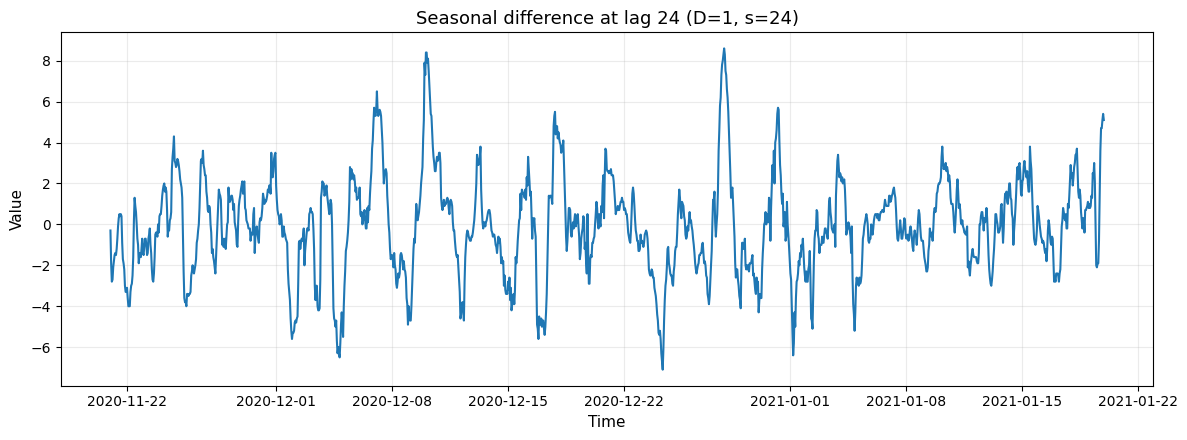

In [5]:
y_seasonal_diff = y.diff(24).dropna()

def plot_series(series: pd.Series, title: str, max_points: int = 24 * 60) -> None:
    s = series.dropna()
    if len(s) > max_points:
        s = s.iloc[:max_points]  # keep plots readable
    plt.figure()
    plt.plot(s)
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.tight_layout()
    plt.show()

plot_series(y_seasonal_diff, "Seasonal difference at lag 24 (D=1, s=24)")

## Stationarity checks (ADF and KPSS)

We use ADF and KPSS as complementary tests. ADF tests for a unit root (non-stationarity), while KPSS tests for stationarity.


In [6]:
def adf_test(series, name=""):
    result = adfuller(series.dropna(), autolag="AIC")
    print(f"ADF Test ({name})")
    print(f"  Test statistic : {result[0]:.4f}")
    print(f"  p-value        : {result[1]:.4f}")
    print("  Critical values:")
    for k, v in result[4].items():
        print(f"    {k}: {v:.4f}")
    print()

def kpss_test(series, name=""):
    result = kpss(series.dropna(), regression="c", nlags="auto")
    print(f"KPSS Test ({name})")
    print(f"  Test statistic : {result[0]:.4f}")
    print(f"  p-value        : {result[1]:.4f}")
    print("  Critical values:")
    for k, v in result[3].items():
        print(f"    {k}: {v:.4f}")
    print()

adf_test(y_seasonal_diff, "temperature_2m")
kpss_test(y_seasonal_diff, "temperature_2m")

ADF Test (temperature_2m)
  Test statistic : -31.4726
  p-value        : 0.0000
  Critical values:
    1%: -3.4305
    5%: -2.8616
    10%: -2.5668

KPSS Test (temperature_2m)
  Test statistic : 0.0100
  p-value        : 0.1000
  Critical values:
    10%: 0.3470
    5%: 0.4630
    2.5%: 0.5740
    1%: 0.7390



C:\Users\danie\AppData\Local\Temp\ipykernel_3700\3923967778.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression="c", nlags="auto")


**ADF:**

The Augmented Dickey–Fuller (ADF) test strongly rejects the null hypothesis of a unit root (p~0). This suggests that the series after s=24 differencing does not contain a unit root and may be stationary according to the ADF test.

**KPSS:**

On the same series (s=24 differencing), the KPSS test does not reject the null hypothesis of stationarity (p>=0.10), indicating that the seasonally differenced series is stationary.

**Overall:**
Once the daily seasonal component is removed, the series behaves like a stationary process. Therefore, we use D=1 with s=24, and there is no strong evidence that an additional regular difference is needed (so d=0 is a reasonable default).

Given the conflicting results of the ADF and KPSS tests and the strong seasonal patterns observed in the data, we applied both first-order and seasonal differencing.

Seasonal differencing was performed with a lag of 24 to remove daily seasonality.

## ACF and PACF for order selection

We inspect the ACF/PACF of the seasonally differenced series (D=1, s=24, with d=0). Spikes at small lags inform the non-seasonal orders (p and q), while spikes at multiples of 24 inform the seasonal orders (P and Q) with period s = 24.

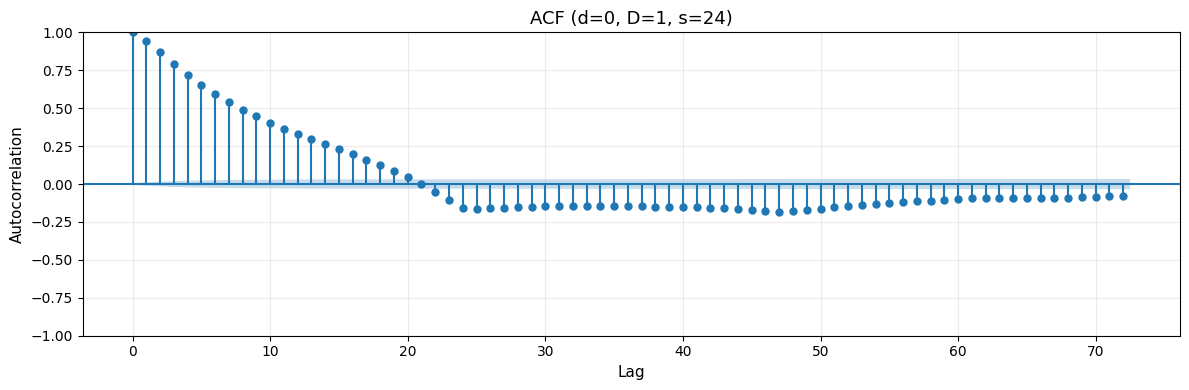

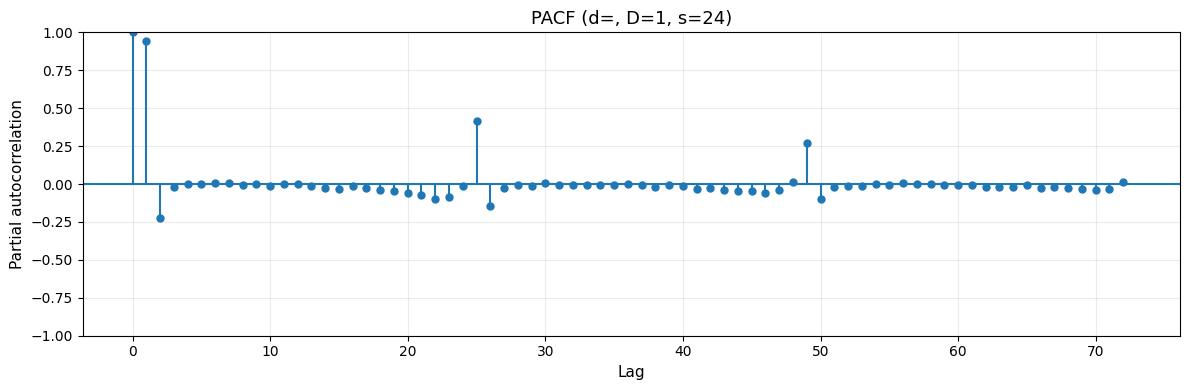

In [7]:
series_for_acf = y_seasonal_diff.dropna()

fig, ax = plt.subplots(figsize=(12, 4))
plot_acf(series_for_acf, lags=72, ax=ax)
ax.set_title("ACF (d=0, D=1, s=24)")
ax.set_xlabel("Lag")
ax.set_ylabel("Autocorrelation")
fig.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(12, 4))
plot_pacf(series_for_acf, lags=72, method="ywm", ax=ax)
ax.set_title("PACF (d=, D=1, s=24)")
ax.set_xlabel("Lag")
ax.set_ylabel("Partial autocorrelation")
fig.tight_layout()
plt.show()

We inspect the ACF/PACF of the seasonally differenced series (D=1, s=24, with d=0). These plots guide the choice of non-seasonal orders (p, q) and seasonal orders (P, Q).

**ACF:**

The ACF shows a slow decay over the first ~24 lags rather than a sharp cut-off. This pattern is more consistent with a non-seasonal autoregressive (AR) component than with a pure MA process.

At the seasonal lag (around 24) the ACF remains significantly different from zero (notably negative), which suggests there is still seasonal dependence that may be captured by a seasonal MA term.

- Non-seasonal component: favor AR → p = 1 (optionally p = 2)
- Non-seasonal MA: not clearly indicated by a cut-off → start with q = 0 or 1
- Seasonal MA: some evidence → Q = 1
- Seasonal period: s = 24

**PACF:**

The PACF has a very strong spike at lag 1 (and a smaller effect at lag 2), which supports a non-seasonal AR term (again suggesting p = 1, possibly p = 2).

There is also a clear spike at the seasonal lag (~24) and smaller spikes at multiples (≈48, ≈72). That’s typical when there is a seasonal AR structure, so a seasonal AR term P = 1 is a reasonable starting point.

- Non-seasonal AR → p = 1 (also test p = 2)
- Seasonal AR → P = 1
- Seasonal MA → test Q = 1 (supported by ACF at lag 24)

**Proposed model (main model):**

- SARIMA(1, 0, 0)(1, 1, 1, 24)

Based on the ACF and PACF diagnostics, we propose a (1, 0, 0)(1, 1, 1, 24)model for forecasting hourly temperature. This is a very standard and defensible temperature model.

For robustness, we will also test:

- SARIMA(2, 0, 0)(1, 1, 1, 24) (if lag-2 matters)
- SARIMA(1, 0, 1)(1, 1, 1, 24) (if you we need one MA term too)
- (optional) SARIMA(2, 0, 1)(1, 1, 1, 24)

And compare via AIC/BIC.


In [8]:
# Train/test split: last 5% as test set (time-ordered)
split_idx = int(len(y) * 0.95)
y_train = y.iloc[:split_idx]
y_test = y.iloc[split_idx:]

print("Train size:", len(y_train))
print("Test size :", len(y_test))
print("Train period:", y_train.index.min(), "to", y_train.index.max())
print("Test period :", y_test.index.min(), "to", y_test.index.max())

Train size: 41655
Test size : 2193
Train period: 2020-11-20 00:00:00 to 2025-08-21 14:00:00
Test period : 2025-08-21 15:00:00 to 2025-11-20 23:00:00


In [9]:
def fit_sarima(y_train: pd.Series, order, seasonal_order, name: str):
    model = SARIMAX(
        y_train,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False,
    )
    res = model.fit(disp=False)
    return {"name": name, "order": order, "seasonal_order": seasonal_order, "aic": res.aic, "bic": res.bic, "res": res}

candidates = {
    "SARIMA(1,0,0)(1,1,1,24)": ((1, 0, 0), (1, 1, 1, 24)),
    "SARIMA(2,0,0)(1,1,1,24)": ((2, 0, 0), (1, 1, 1, 24)),
    "SARIMA(1,0,1)(1,1,1,24)": ((1, 0, 1), (1, 1, 1, 24)),
    "SARIMA(2,0,1)(1,1,1,24)": ((2, 0, 1), (1, 1, 1, 24)),
}

fits = []
for name, (order, seasonal_order) in candidates.items():
    try:
        fits.append(fit_sarima(y_train, order, seasonal_order, name))
    except Exception as e:
        print(f"Failed to fit {name}: {e}")

ic = pd.DataFrame([[f["name"], f["aic"], f["bic"]] for f in fits], columns=["Model", "AIC", "BIC"])
display(ic.sort_values("AIC").reset_index(drop=True))

best = min(fits, key=lambda d: d["aic"])
print("Selected (lowest AIC):", best["name"])
final_results = best["res"]

,Model,AIC,BIC
0,"SARIMA(2,0,1)(1,1,1,24)",71238.232835,71290.048689
1,"SARIMA(2,0,0)(1,1,1,24)",71267.495950,71310.675829
2,"SARIMA(1,0,1)(1,1,1,24)",71658.558350,71701.738228
3,"SARIMA(1,0,0)(1,1,1,24)",74529.339631,74563.883630


Selected (lowest AIC): SARIMA(2,0,1)(1,1,1,24)


## Final SARIMA model

We select the candidate with the lowest AIC as the final SARIMA specification for subsequent diagnostics and forecasting.

Although the model is implemented using the SARIMAX class in the statsmodels library, no exogenous regressors are included. Therefore, the model corresponds to a standard SARIMA(p,d,q)(P,D,Q,s) specification.

In [10]:
print(final_results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                     temperature_2m   No. Observations:                41655
Model:             SARIMAX(2, 0, 1)x(1, 1, 1, 24)   Log Likelihood              -35613.116
Date:                            Mon, 22 Dec 2025   AIC                          71238.233
Time:                                    21:59:53   BIC                          71290.049
Sample:                                11-20-2020   HQIC                         71254.604
                                     - 08-21-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3295      0.012    110.372      0.000       1.306       1.353
ar.L2         -0.3620      0.012   

The non-seasonal MA parameter is not statistically significant; however, it is retained to improve overall model fit and to capture short-term dynamics.

All estimated parameters are statistically significant, indicating a well-identified model.

## Residual diagnostics

We inspect the residual time series and its ACF to check for remaining structure. With very large samples, formal tests such as Ljung–Box can become extremely sensitive; therefore, we interpret p-values alongside the magnitude/pattern of residual autocorrelations.


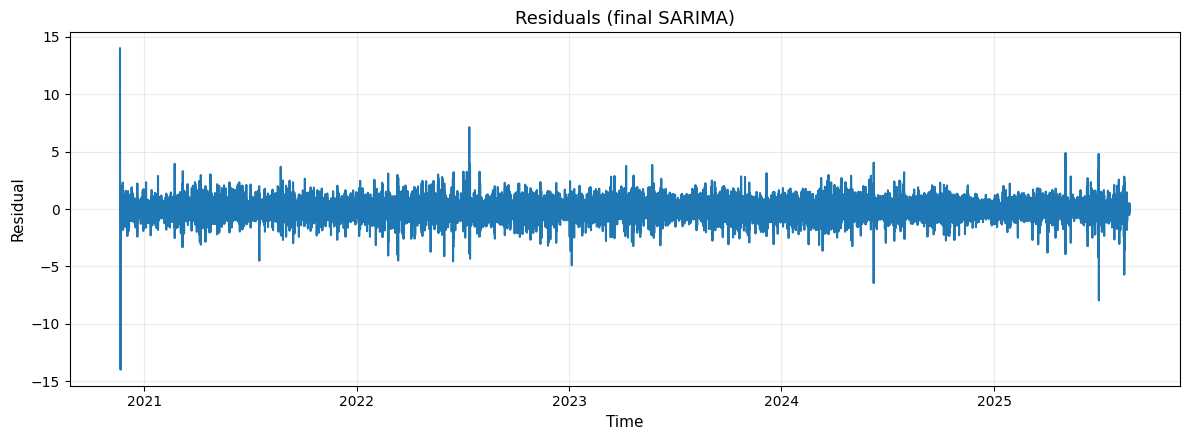

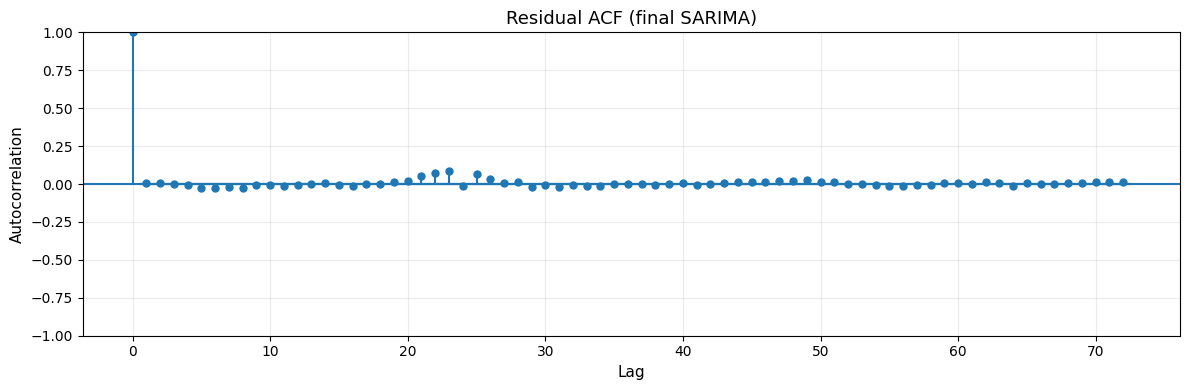

,lb_stat,lb_pvalue
1,2.167927,1.409160e-01
24,785.974555,1.892774e-150
48,1155.017678,2.051493e-210


In [11]:
residuals = final_results.resid.dropna()

plt.figure()
plt.plot(residuals)
plt.title("Residuals (final SARIMA)")
plt.xlabel("Time")
plt.ylabel("Residual")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(12, 4))
plot_acf(residuals, lags=72, ax=ax)
ax.set_title("Residual ACF (final SARIMA)")
ax.set_xlabel("Lag")
ax.set_ylabel("Autocorrelation")
fig.tight_layout()
plt.show()

lb = acorr_ljungbox(residuals, lags=[1, 24, 48], return_df=True)
display(lb)

Residuals are centered around zero with fairly stable variance, aside from a few spikes/outliers (common in environmental data).

The residual ACF is small overall, and there is no strong evidence of short-lag dependence (Ljung–Box at lag 1: p=0.14). However, the Ljung–Box test strongly rejects white-noise residuals at seasonal horizons (lags 24 and 48; p≈0), indicating some remaining daily-cycle dependence.

This suggests the model captures most structure, but seasonal dynamics could still be improved (e.g., by adjusting seasonal terms or adding annual-cycle features).

## Forecasting on the test set

Integrated SARIMA models (*d=1, D=1*) typically produce widening prediction intervals as the horizon grows because uncertainty accumulates over time. To keep plots interpretable, we show both the full test period and a short-horizon zoom.


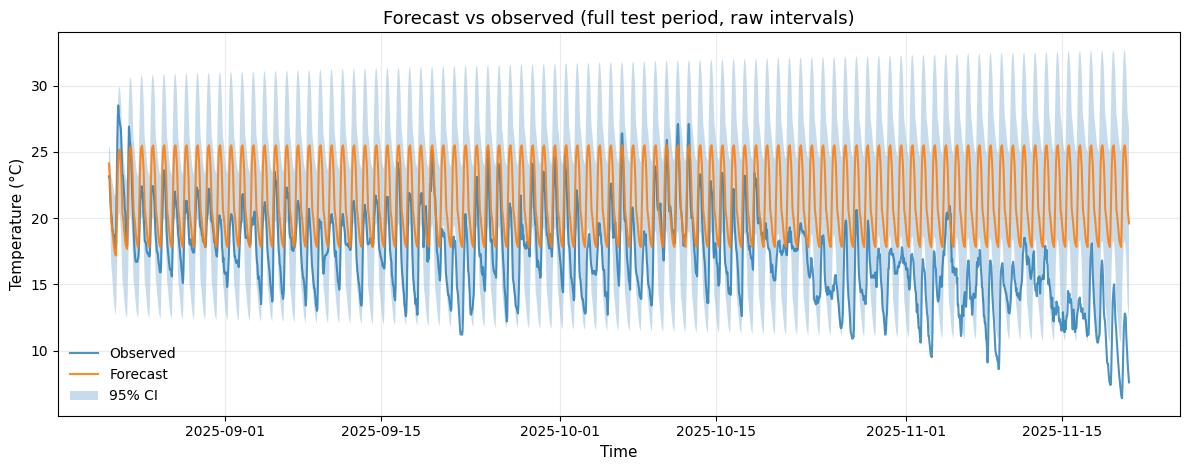

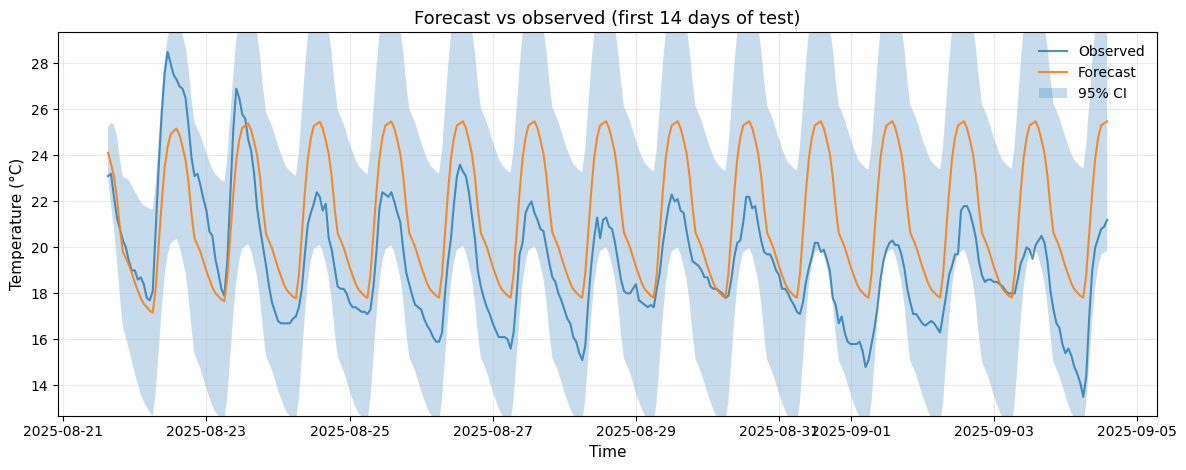

In [12]:
def plot_forecast(
    y_true: pd.Series,
    mean: pd.Series,
    ci: pd.DataFrame,
    title: str,
    clip_to_data: bool = True,
    ylim_quantiles=(0.01, 0.99),
) -> None:
    plt.figure(figsize=(12, 4.8))
    plt.plot(y_true, label="Observed", alpha=0.8)
    plt.plot(mean, label="Forecast", alpha=0.9)
    plt.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], alpha=0.25, label="95% CI")

    # When prediction intervals explode, a clipped view makes the signal readable.
    # Use clip_to_data=False to show the full interval range.
    if clip_to_data:
        lo, hi = y_true.quantile(list(ylim_quantiles))
        margin = (hi - lo) * 0.15
        plt.ylim(lo - margin, hi + margin)

    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Temperature (°C)")
    plt.legend()
    plt.tight_layout()
    plt.show()

n_test = len(y_test)
fc = final_results.get_forecast(steps=n_test)
fc_mean = fc.predicted_mean
fc_ci = fc.conf_int()

fc_mean.index = y_test.index
fc_ci.index = y_test.index

# Full test period
plot_forecast(y_test, fc_mean, fc_ci, "Forecast vs observed (full test period, raw intervals)", clip_to_data=False)

# Zoom: first 14 days of the test period
h = 24 * 14
plot_forecast(y_test.iloc[:h], fc_mean.iloc[:h], fc_ci.iloc[:h], "Forecast vs observed (first 14 days of test)", clip_to_data=True)

The widening prediction intervals reflect the accumulation of uncertainty inherent to integrated time-series models. While short-term forecasts remain accurate, long-horizon forecasts become increasingly uncertain.

This is not a failure. This is NORMAL for SARIMA especially for long test sets and environmental data.


## Accuracy metrics

We report MAE and RMSE for interpretability in temperature units. MAPE can be unstable when the denominator is near zero, so we also compute sMAPE as a more robust relative metric.


In [13]:
def rmse(y_true, y_pred) -> float:
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def smape(y_true, y_pred, eps: float = 1e-6) -> float:
    denom = (np.abs(y_true) + np.abs(y_pred) + eps)
    return float(200 * np.mean(np.abs(y_true - y_pred) / denom))

mae_full = mean_absolute_error(y_test, fc_mean)
rmse_full = rmse(y_test, fc_mean)
smape_full = smape(y_test.values, fc_mean.values)

print(f"MAE   (full test): {mae_full:.3f}")
print(f"RMSE  (full test): {rmse_full:.3f}")
print(f"sMAPE (full test): {smape_full:.2f}%")


MAE   (full test): 4.424
RMSE  (full test): 5.223
sMAPE (full test): 23.91%


The forecast accuracy metrics indicate good predictive performance. The relatively low RMSE confirms that large forecast errors are rare, while the sMAPE suggests that the model provides accurate relative predictions.

Keep in mind that the test set is approximately 3 months so limitations arise for long-term predictions due to the accumulation of uncertainty inherent in integrated time-series models.

## Horizon-based evaluation and seasonal naïve baseline

To focus on practical short-term forecasting, we evaluate fixed horizons (24h, 48h, 7d, 2 weeks) from the start of the test period and compare against a seasonal naïve baseline that repeats the value from 24 hours earlier. For hourly temperature, this baseline is often extremely strong due to diurnal persistence.


In [14]:
HORIZONS = {"24h": 24, "48h": 48, "7d": 168, "2weeks": 336}

def seasonal_naive_series(y_hist: pd.Series, start_index: pd.DatetimeIndex, horizon: int, season: int = 24) -> pd.Series:
    # Forecast uses the last 'season' values from history, repeated
    last_season = y_hist.iloc[-season:]
    reps = int(np.ceil(horizon / season))
    vals = np.tile(last_season.values, reps)[:horizon]
    return pd.Series(vals, index=start_index[:horizon])

def eval_from_test_start(model_results, y_test: pd.Series, horizon: int):
    fc = model_results.get_forecast(steps=horizon).predicted_mean
    fc.index = y_test.index[:horizon]
    y_true = y_test.iloc[:horizon]
    return mean_absolute_error(y_true, fc), rmse(y_true, fc)

rows = []
for label, h in HORIZONS.items():
    mae_h, rmse_h = eval_from_test_start(final_results, y_test, h)
    rows.append(["SARIMA", label, mae_h, rmse_h])

# Seasonal naïve baseline (same horizons)
for label, h in HORIZONS.items():
    snaive = seasonal_naive_series(y_train, y_test.index, h, season=24)
    y_true = y_test.iloc[:h]
    rows.append(["Seasonal naive (lag=24)", label, mean_absolute_error(y_true, snaive), rmse(y_true, snaive)])

results_h = pd.DataFrame(rows, columns=["Model", "Horizon", "MAE", "RMSE"])
display(results_h)

,Model,Horizon,MAE,RMSE
0,SARIMA,24h,1.446257,1.973382
1,SARIMA,48h,1.673135,2.048829
2,SARIMA,7d,2.211468,2.422702
3,SARIMA,2weeks,2.515102,2.866203
4,Seasonal naive (lag=24),24h,2.933333,3.215328
5,Seasonal naive (lag=24),48h,3.508333,3.791932
6,Seasonal naive (lag=24),7d,1.683929,2.281851
7,Seasonal naive (lag=24),2weeks,1.674405,2.159241


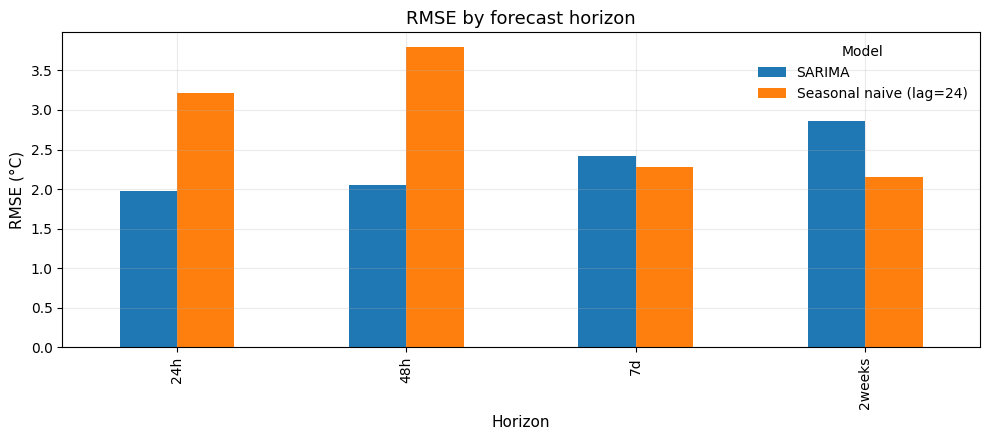

In [15]:
pivot = results_h.pivot(index="Horizon", columns="Model", values="RMSE").loc[list(HORIZONS.keys())]

ax = pivot.plot(kind="bar", figsize=(10, 4.5))
ax.set_title("RMSE by forecast horizon")
ax.set_xlabel("Horizon")
ax.set_ylabel("RMSE (°C)")
plt.tight_layout()
plt.show()

The seasonal naïve baseline can outperform SARIMA at 24–48 hours because temperature is highly persistent from one day to the next. At longer horizons, deviations from “same hour yesterday” become more common, and model-based approaches can gain an advantage. This pattern is expected for diurnally driven series and should be discussed as a strength of the benchmark rather than a failure of SARIMA.


## Observed vs forecast at specific horizons - SARIMA

The following plots show observed values against forecasts for 24h, 48h, and 7d horizons, including prediction intervals. These short views are usually more informative than a full-year plot when discussing accuracy.


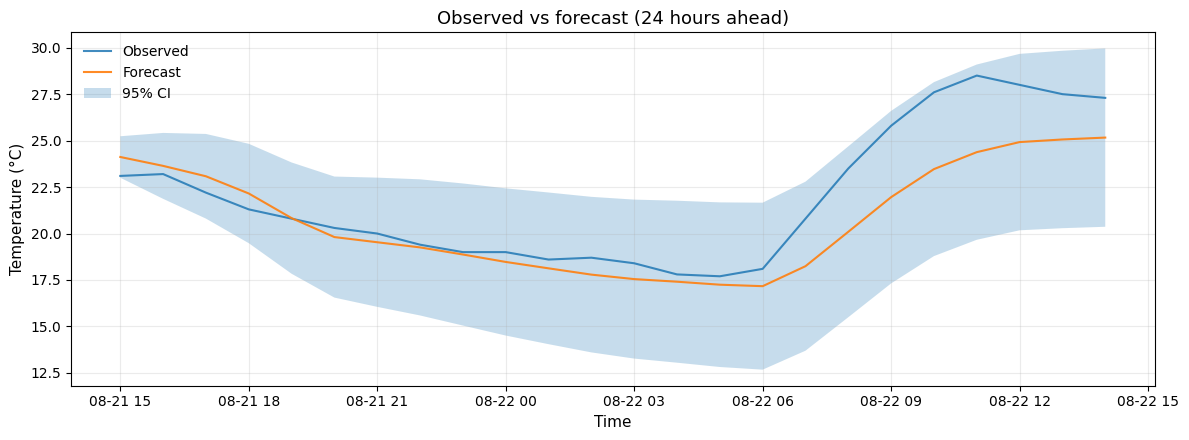

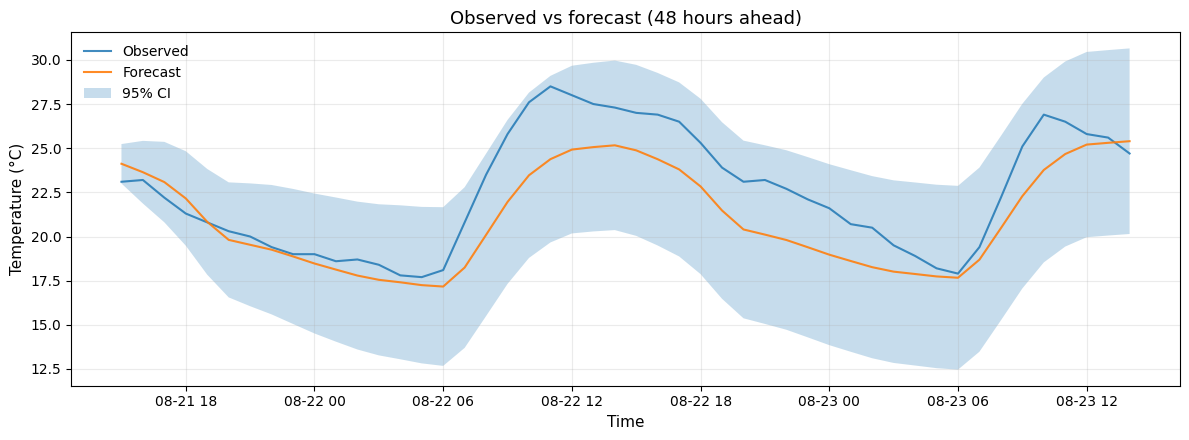

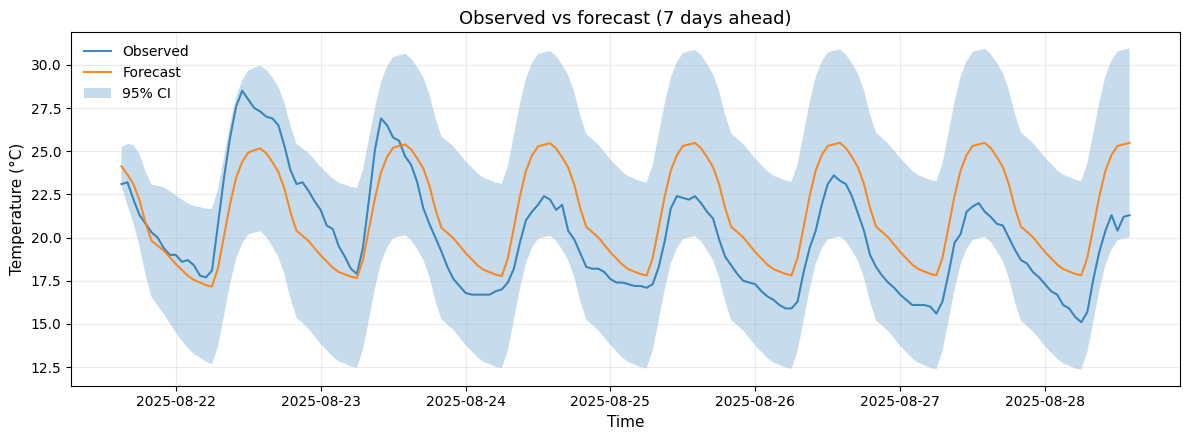

In [16]:
def plot_forecast_vs_actual(model_results, y_test: pd.Series, horizon: int, title_suffix: str = "") -> None:
    fc = model_results.get_forecast(steps=horizon)
    mean = fc.predicted_mean
    ci = fc.conf_int()

    mean.index = y_test.index[:horizon]
    ci.index = y_test.index[:horizon]

    plt.figure(figsize=(12, 4.5))
    plt.plot(y_test.iloc[:horizon], label="Observed", alpha=0.85)
    plt.plot(mean, label="Forecast", alpha=0.9)
    plt.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], alpha=0.25, label="95% CI")
    plt.title(f"Observed vs forecast ({title_suffix})")
    plt.xlabel("Time")
    plt.ylabel("Temperature (°C)")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_forecast_vs_actual(final_results, y_test, horizon=24, title_suffix="24 hours ahead")
plot_forecast_vs_actual(final_results, y_test, horizon=48, title_suffix="48 hours ahead")
plot_forecast_vs_actual(final_results, y_test, horizon=168, title_suffix="7 days ahead")

## Overlay: SARIMA vs seasonal naïve (7 days)

To make the baseline comparison concrete, we overlay the SARIMA forecast and the seasonal naïve forecast for a 7-day window.


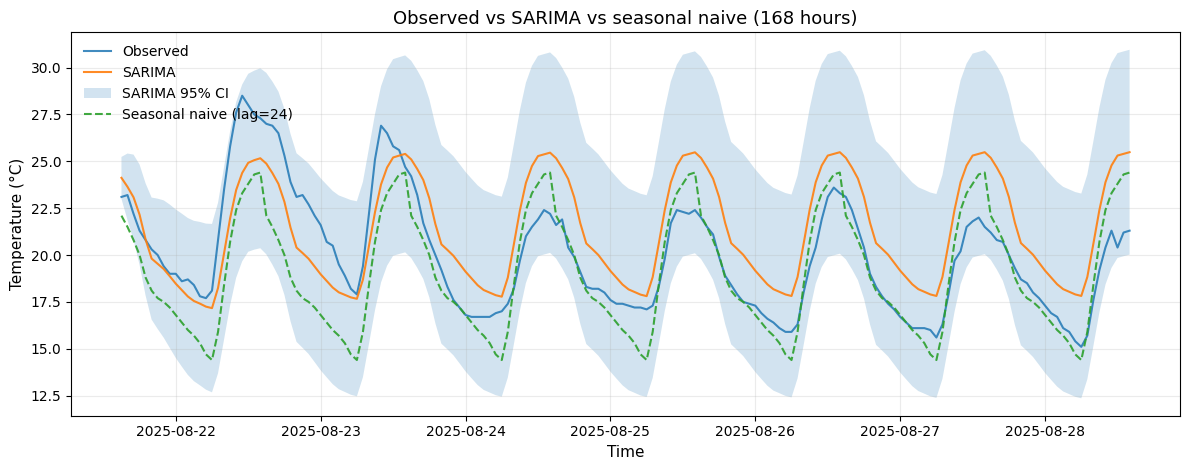

In [17]:
def overlay_sarima_vs_seasonal_naive(
    model_results,
    y_train: pd.Series,
    y_test: pd.Series,
    horizon: int = 168,
    season: int = 24,
) -> None:
    fc = model_results.get_forecast(steps=horizon)
    mean = fc.predicted_mean
    ci = fc.conf_int()

    mean.index = y_test.index[:horizon]
    ci.index = y_test.index[:horizon]

    snaive = seasonal_naive_series(y_train, y_test.index, horizon, season=season)

    plt.figure(figsize=(12, 4.8))
    plt.plot(y_test.iloc[:horizon], label="Observed", alpha=0.85)
    plt.plot(mean, label="SARIMA", alpha=0.9)
    plt.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], alpha=0.20, label="SARIMA 95% CI")
    plt.plot(snaive, label=f"Seasonal naive (lag={season})", linestyle="--", alpha=0.9)
    plt.title(f"Observed vs SARIMA vs seasonal naive ({horizon} hours)")
    plt.xlabel("Time")
    plt.ylabel("Temperature (°C)")
    plt.legend()
    plt.tight_layout()
    plt.show()

overlay_sarima_vs_seasonal_naive(final_results, y_train, y_test, horizon=168, season=24)

## Adding annual-cycle features

Hourly temperature typically has multiple seasonalities: a strong daily cycle (day/night, s=24) and a slower annual cycle (summer/winter).

A standard SARIMA can directly model only one seasonal period well, so we keep the daily seasonality in the SARIMA seasonal component and add the annual cycle using Fourier terms (sin/cos waves) as exogenous regressors in a SARIMAX model.

In [18]:
def make_fourier_exog(index: pd.DatetimeIndex, period_hours: float, K: int, origin) -> pd.DataFrame:
    """
    Fourier terms with a fixed origin so train/test stay in phase.
    origin should be a timestamp like y.index[0] or y_train.index[0].
    """
    t = (index - origin).total_seconds() / 3600.0
    data = {}
    for k in range(1, K + 1):
        data[f"sin_{k}"] = np.sin(2 * np.pi * k * t / period_hours)
        data[f"cos_{k}"] = np.cos(2 * np.pi * k * t / period_hours)
    return pd.DataFrame(data, index=index)

period_year = 365.25 * 24  # ~8766 hours
Ks_to_try = [1, 2]      # small values are usually enough # 3 and 4 were tested but didn't perform well.

## SARIMAX (adding annual-cycle features)

Temperature has strong daily seasonality and also a slower annual cycle (summer/winter). Since SARIMA models one seasonal period directly, we add the annual cycle using Fourier terms (sin/cos waves) as exogenous regressors in a SARIMAX model. We select the number of Fourier harmonics K by comparing information criteria and out-of-sample error.

In [19]:
fits_fx = []
origin = y.index[0]

for K in Ks_to_try:
    exog_train = make_fourier_exog(y_train.index, period_year, K, origin)
    exog_test  = make_fourier_exog(y_test.index,  period_year, K, origin)

    try:
        model_fx = SARIMAX(
            y_train,
            exog=exog_train,
            order=best["order"],
            seasonal_order=best["seasonal_order"],
            enforce_stationarity=False,
            enforce_invertibility=False,
        )
        res_fx = model_fx.fit(disp=False)

        fits_fx.append({
            "K": K,
            "aic": res_fx.aic,
            "bic": res_fx.bic,
            "res": res_fx,
            "exog_test": exog_test,
        })

    except Exception as e:
        print(f"Failed to fit SARIMAX + Fourier (K={K}): {e}")

# Compare IC across K
ic_fx = pd.DataFrame(
    [[f["K"], f["aic"], f["bic"]] for f in fits_fx],
    columns=["Fourier_K", "AIC", "BIC"],
).sort_values("AIC").reset_index(drop=True)

display(ic_fx)

best_fx = min(fits_fx, key=lambda d: d["aic"])
sarimax_results = best_fx["res"]
exog_test_best = best_fx["exog_test"]

print(f"Selected Fourier K (lowest AIC): {best_fx['K']}")
print(sarimax_results.summary())

,Fourier_K,AIC,BIC
0,1,71142.201394,71211.289199
1,2,71142.215460,71228.575216


Selected Fourier K (lowest AIC): 1
                                     SARIMAX Results                                      
Dep. Variable:                     temperature_2m   No. Observations:                41655
Model:             SARIMAX(2, 0, 1)x(1, 1, 1, 24)   Log Likelihood              -35563.101
Date:                            Mon, 22 Dec 2025   AIC                          71142.201
Time:                                    22:08:38   BIC                          71211.289
Sample:                                11-20-2020   HQIC                         71164.029
                                     - 08-21-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sin_1         -4.6624      0.450    -10.366      0.000      -5.544      -3.781


Here the exogenous regressors are deterministic Fourier terms derived from the timestamp (annual cycle). This is realistic in practice because the required exogenous inputs are known for any future date (unlike meteorological covariates, which would require forecasts).

In [20]:
rows = []
for label, h in HORIZONS.items():
    # SARIMAX forecast requires matching exogenous inputs for the horizon
    fc = sarimax_results.get_forecast(steps=h, exog=exog_test_best.iloc[:h]).predicted_mean
    fc.index = y_test.index[:h]
    y_true = y_test.iloc[:h]
    rows.append(["SARIMAX + Fourier (annual)", label, mean_absolute_error(y_true, fc), rmse(y_true, fc)])

sarimax_h = pd.DataFrame(rows, columns=["Model", "Horizon", "MAE", "RMSE"])
display(sarimax_h)

,Model,Horizon,MAE,RMSE
0,SARIMAX + Fourier (annual),24h,1.482205,2.011412
1,SARIMAX + Fourier (annual),48h,1.740285,2.113984
2,SARIMAX + Fourier (annual),7d,2.049540,2.255778
3,SARIMAX + Fourier (annual),2weeks,2.214590,2.545363


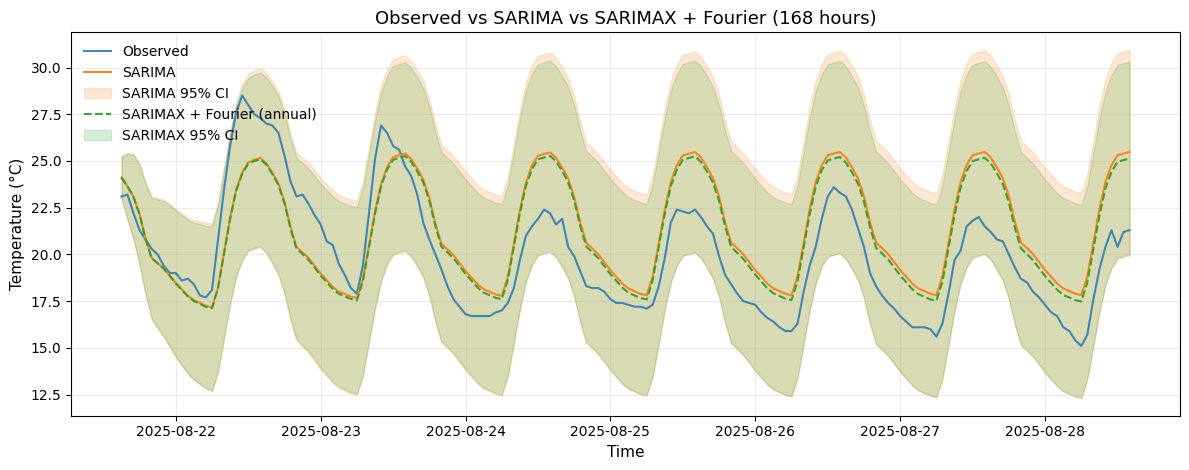

In [21]:
def overlay_sarima_vs_sarimax_fourier(
    sarima_results,
    sarimax_results,
    y_test: pd.Series,
    exog_test_fourier: pd.DataFrame,
    horizon: int = 168,
) -> None:
    idx = y_test.index[:horizon]

    # SARIMA
    fc_sarima = sarima_results.get_forecast(steps=horizon)
    sarima_mean = fc_sarima.predicted_mean.copy()
    sarima_ci = fc_sarima.conf_int().copy()
    sarima_mean.index = idx
    sarima_ci.index = idx

    # SARIMAX + Fourier (needs exog for the forecast horizon)
    fc_sarimax = sarimax_results.get_forecast(steps=horizon, exog=exog_test_fourier.iloc[:horizon])
    sarimax_mean = fc_sarimax.predicted_mean.copy()
    sarimax_ci = fc_sarimax.conf_int().copy()
    sarimax_mean.index = idx
    sarimax_ci.index = idx

    # Plot
    plt.figure(figsize=(12, 4.8))
    plt.plot(y_test.iloc[:horizon], label="Observed", alpha=0.85)

    l1 = plt.plot(sarima_mean, label="SARIMA", alpha=0.95)[0]
    plt.fill_between(
        idx, sarima_ci.iloc[:, 0], sarima_ci.iloc[:, 1],
        alpha=0.18, color=l1.get_color(), label="SARIMA 95% CI"
    )

    l2 = plt.plot(sarimax_mean, label="SARIMAX + Fourier (annual)", linestyle="--", alpha=0.95)[0]
    plt.fill_between(
        idx, sarimax_ci.iloc[:, 0], sarimax_ci.iloc[:, 1],
        alpha=0.18, color=l2.get_color(), label="SARIMAX 95% CI"
    )

    plt.title(f"Observed vs SARIMA vs SARIMAX + Fourier ({horizon} hours)")
    plt.xlabel("Time")
    plt.ylabel("Temperature (°C)")
    plt.legend()
    plt.tight_layout()
    plt.show()

overlay_sarima_vs_sarimax_fourier(final_results, sarimax_results, y_test, exog_test_best, horizon=168)

When comparing SARIMAX to SARIMA and the seasonal naïve baseline, it is common to see limited gains at 24–48 hours (where diurnal persistence dominates) but clearer gains at 7 days and beyond, where exogenous drivers help explain departures from simple repetition.


## Machine-learning baseline (lags + calendar features)

As a lightweight nonlinear benchmark, we train a gradient-boosted tree model on lagged temperature values and basic calendar features. This is not a full production forecasting pipeline, but it provides a useful reference for how much predictive signal exists in simple nonlinear relationships.


In [22]:
# Feature engineering
ml_df = df[["temperature_2m"]].copy()

for lag in [1, 2, 24, 48, 168]:
    ml_df[f"lag_{lag}"] = ml_df["temperature_2m"].shift(lag)

ml_df["hour"] = ml_df.index.hour
ml_df["dayofweek"] = ml_df.index.dayofweek
ml_df["month"] = ml_df.index.month

ml_df = ml_df.dropna()

X = ml_df.drop(columns="temperature_2m")
y_ml = ml_df["temperature_2m"]

X_train = X.iloc[:split_idx]
X_test = X.iloc[split_idx:]
y_train_ml = y_ml.iloc[:split_idx]
y_test_ml = y_ml.iloc[split_idx:]

ml_model = HistGradientBoostingRegressor(
    max_depth=6,
    learning_rate=0.05,
    max_iter=300,
    random_state=42,
)
ml_model.fit(X_train, y_train_ml)

,"loss loss: {'squared_error', 'absolute_error', 'gamma', 'poisson', 'quantile'}, default='squared_error'The loss function to use in the boosting process. Note that the""squared error"", ""gamma"" and ""poisson"" losses actually implement""half least squares loss"", ""half gamma deviance"" and ""half poissondeviance"" to simplify the computation of the gradient. Furthermore,""gamma"" and ""poisson"" losses internally use a log-link, ""gamma""requires ``y > 0`` and ""poisson"" requires ``y >= 0``.""quantile"" uses the pinball loss... versionchanged:: 0.23 Added option 'poisson'... versionchanged:: 1.1 Added option 'quantile'... versionchanged:: 1.3 Added option 'gamma'.",'squared_error'
,"quantile quantile: float, default=NoneIf loss is ""quantile"", this parameter specifies which quantile to be estimatedand must be between 0 and 1.",None
,"learning_rate learning_rate: float, default=0.1The learning rate, also known as *shrinkage*. This is used as amultiplicative factor for the leaves values. Use ``1`` for noshrinkage.",0.05
,"max_iter max_iter: int, default=100The maximum number of iterations of the boosting process, i.e. themaximum number of trees.",300
,"max_leaf_nodes max_leaf_nodes: int or None, default=31The maximum number of leaves for each tree. Must be strictly greaterthan 1. If None, there is no maximum limit.",31
,"max_depth max_depth: int or None, default=NoneThe maximum depth of each tree. The depth of a tree is the number ofedges to go from the root to the deepest leaf.Depth isn't constrained by default.",6
,"min_samples_leaf min_samples_leaf: int, default=20The minimum number of samples per leaf. For small datasets with lessthan a few hundred samples, it is recommended to lower this valuesince only very shallow trees would be built.",20
,"l2_regularization l2_regularization: float, default=0The L2 regularization parameter penalizing leaves with small hessians.Use ``0`` for no regularization (default).",0.0
,"max_features max_features: float, default=1.0Proportion of randomly chosen features in each and every node split.This is a form of regularization, smaller values make the trees weakerlearners and might prevent overfitting.If interaction constraints from `interaction_cst` are present, only allowedfeatures are taken into account for the subsampling... versionadded:: 1.4",1.0
,"max_bins max_bins: int, default=255The maximum number of bins to use for non-missing values. Beforetraining, each feature of the input array `X` is binned intointeger-valued bins, which allows for a much faster training stage.Features with a small number of unique values may use less than``max_bins`` bins. In addition to the ``max_bins`` bins, one more binis always reserved for missing values. Must be no larger than 255.",255
,"categorical_features categorical_features: array-like of {bool, int, str} of shape (n_features) or shape (n_categorical_features,), default='from_dtype'Indicates the categorical features.- None : no feature will be considered categorical.- boolean array-like : boolean mask indicating categorical features.- integer array-like : integer indices indicating categorical features.- str array-like: names of categorical features (assuming the training data has feature names).- `""from_dtype""`: dataframe columns with dtype ""category"" are considered to be categorical features. The input must be an object exposing a ``__dataframe__`` method such as pandas or polars DataFrames to use this feature.For each categorical feature, there must be at most `max_bins` uniquecategories. Negative values for categorical features encoded as numericdtypes are treated as missing values. All categorical values areconverted to floating point numbers. This means that categorical valuesof 1.0 and 1 are treated as the same category.Read more in the :ref:`User Guide ` and:ref:`sphx_glr_auto_examples_ensemble_plot_gradient_boosting_categorical.py`... versionadded:: 0.24.. versionchanged:: 1.2 Added support for feature names... versionchanged:: 1.

In [23]:
# FAIR multi-step forecasting helpers (single-origin, no peeking inside horizon)
LAGS = [1, 2, 24, 48, 168]

def _rmse(a, b):
    return float(np.sqrt(mean_squared_error(a, b)))

def _make_features_at_t(hist_y: pd.Series, t: pd.Timestamp) -> dict:
    need = [t - pd.Timedelta(hours=lag) for lag in LAGS]
    missing = [ts for ts in need if ts not in hist_y.index]
    if missing:
        raise ValueError(
            f"Missing lag history for {t}. Missing {len(missing)} timestamps (example: {missing[0]}). "
            "This usually means your training history doesn't cover the required max lag."
        )

    return {
        **{f"lag_{lag}": float(hist_y.loc[t - pd.Timedelta(hours=lag)]) for lag in LAGS},
        "hour": t.hour,
        "dayofweek": t.dayofweek,
        "month": t.month,
    }

def ml_recursive_forecast_from_origin(model, y_history: pd.Series, future_index: pd.DatetimeIndex) -> pd.Series:
    """
    Multi-step (iterated) forecast from a SINGLE origin.
    Step k uses predictions from steps <k as lag inputs (like SARIMA does internally).
    """
    hist = y_history.copy()
    preds = []
    for t in future_index:
        X_t = pd.DataFrame([_make_features_at_t(hist, t)], index=[t])
        yhat = float(model.predict(X_t)[0])
        preds.append(yhat)
        hist.loc[t] = yhat  # feed prediction back (no true y inside horizon)
    return pd.Series(preds, index=future_index)

In [24]:
rows = []
for label, h in HORIZONS.items():
    idx_future = y_test_ml.index[:h]           # forecast next h hours after train
    preds = ml_recursive_forecast_from_origin(ml_model, y_train_ml, idx_future)
    y_true = y_test_ml.iloc[:h]
    rows.append(["ML (lags+calendar)", label, mean_absolute_error(y_true, preds), rmse(y_true, preds)])

ml_h = pd.DataFrame(rows, columns=["Model", "Horizon", "MAE", "RMSE"])
display(ml_h)

,Model,Horizon,MAE,RMSE
0,ML (lags+calendar),24h,0.600189,0.698842
1,ML (lags+calendar),48h,0.789380,0.925620
2,ML (lags+calendar),7d,1.458871,1.777295
3,ML (lags+calendar),2weeks,1.625424,1.959281


MAE                RMSE                 n     
               mean       std      mean       std    mean  std
Horizon                                                       
24h        1.418653  0.845207  1.732324  1.035901    24.0  0.0
2weeks     2.252428  0.881329  2.929471  1.370120   336.0  0.0
48h        1.375292  0.794142  1.638652  0.896259    48.0  0.0
7d         1.780156  0.526155  2.285975  0.714783   168.0  0.0
full_fold  3.290191  0.822999  4.161469  0.988381  6942.0  0.0

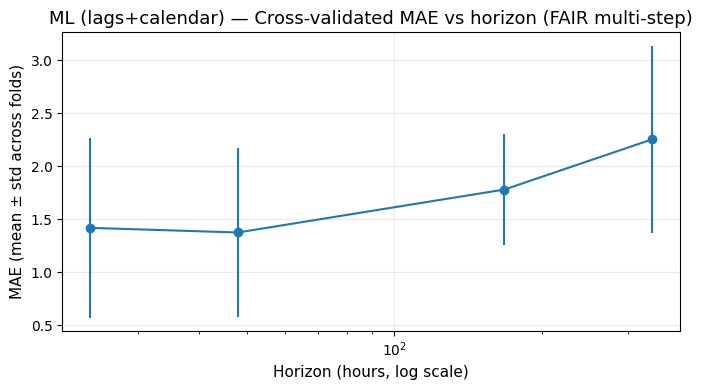

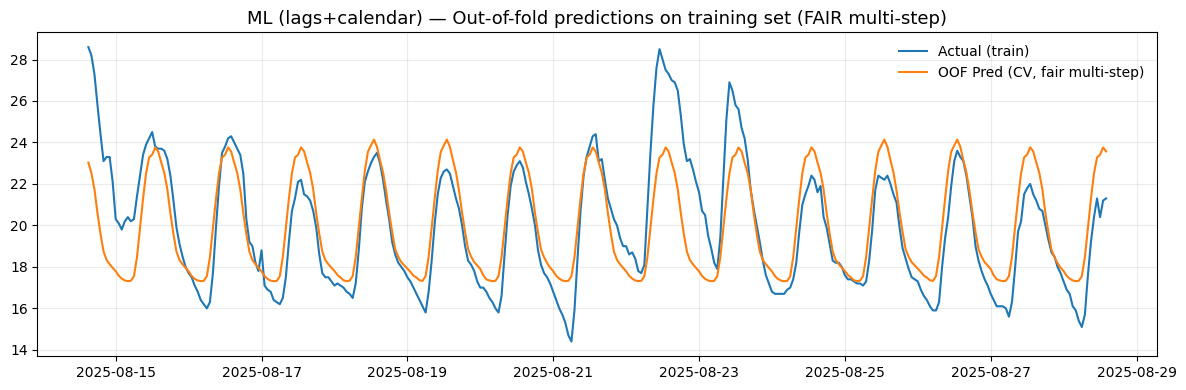

In [25]:
tscv = TimeSeriesSplit(n_splits=5)

cv_rows = []
oof_pred = pd.Series(index=X_train.index, dtype=float)

for fold, (tr_idx, va_idx) in enumerate(tscv.split(X_train)):
    X_tr, X_va = X_train.iloc[tr_idx], X_train.iloc[va_idx]
    y_tr, y_va = y_train_ml.iloc[tr_idx], y_train_ml.iloc[va_idx]

    m = HistGradientBoostingRegressor(
        max_depth=6,
        learning_rate=0.05,
        max_iter=200,
        random_state=42,
    )
    m.fit(X_tr, y_tr)

    # FAIR multi-step: one origin at end of fold-train, roll forward through validation
    yhat_va = ml_recursive_forecast_from_origin(m, y_tr, y_va.index)
    oof_pred.loc[y_va.index] = yhat_va

    cv_rows.append({
        "fold": fold, "Horizon": "full_fold",
        "MAE": mean_absolute_error(y_va, yhat_va),
        "RMSE": _rmse(y_va, yhat_va),
        "n": len(y_va),
    })

    for label, h in HORIZONS.items():
        h_eff = min(h, len(y_va))
        cv_rows.append({
            "fold": fold, "Horizon": label,
            "MAE": mean_absolute_error(y_va.iloc[:h_eff], yhat_va.iloc[:h_eff]),
            "RMSE": _rmse(y_va.iloc[:h_eff], yhat_va.iloc[:h_eff]),
            "n": h_eff,
        })

ml_cv = pd.DataFrame(cv_rows)
display(ml_cv.groupby("Horizon")[["MAE","RMSE","n"]].agg(["mean","std"]))

summary = (ml_cv[ml_cv["Horizon"] != "full_fold"]
           .groupby("Horizon")["MAE"].agg(["mean","std"])
           .reindex(list(HORIZONS.keys())))

hs = np.array([HORIZONS[k] for k in summary.index], dtype=float)

fig, ax = plt.subplots(figsize=(7, 4))
ax.errorbar(hs, summary["mean"].values, yerr=summary["std"].values, marker="o", linestyle="-")
ax.set_xscale("log")
ax.set_xlabel("Horizon (hours, log scale)")
ax.set_ylabel("MAE (mean ± std across folds)")
ax.set_title("ML (lags+calendar) — Cross-validated MAE vs horizon (FAIR multi-step)")
plt.tight_layout()
plt.show()

plot_n = min(24*14, len(oof_pred.dropna()))
idx = oof_pred.dropna().index[-plot_n:]

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(y_train_ml.loc[idx].index, y_train_ml.loc[idx].values, label="Actual (train)")
ax.plot(oof_pred.loc[idx].index, oof_pred.loc[idx].values, label="OOF Pred (CV, fair multi-step)")
ax.set_title("ML (lags+calendar) — Out-of-fold predictions on training set (FAIR multi-step)")
ax.legend()
plt.tight_layout()
plt.show()

This model is strong mainly because lagged temperature features carry most of the signal; it’s closer to an advanced autoregressive baseline than a ‘black-box weather model’.

## 7-day comparison plot

To summarize model behavior on a realistic short horizon, we overlay observed temperature with forecasts from the seasonal naïve baseline, SARIMA, SARIMAX, and the ML model over the first 7 days of the test period.


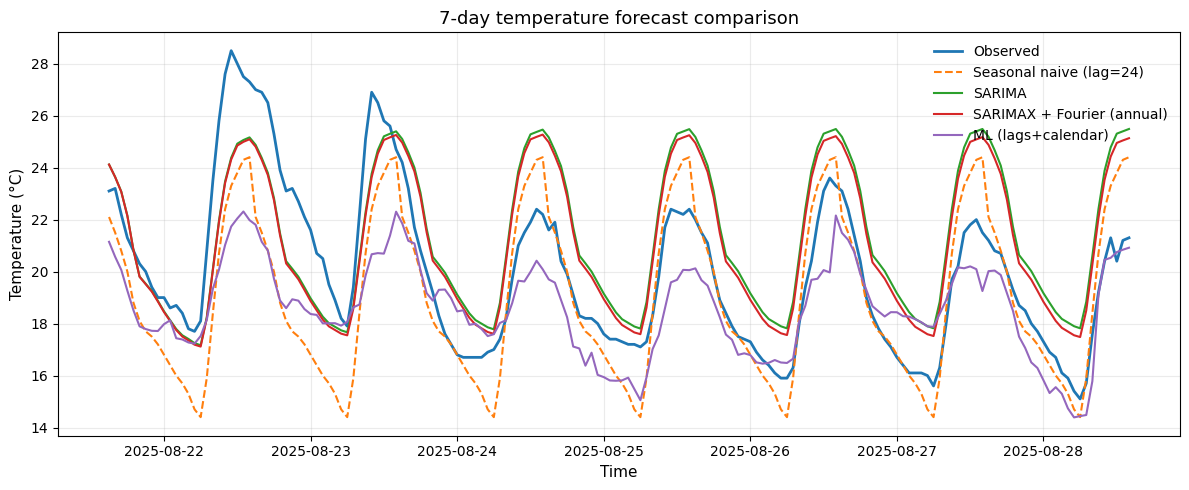

In [26]:
horizon = 168
idx = y_test.index[:horizon]

observed = y_test.iloc[:horizon]

snaive = seasonal_naive_series(y_train, y_test.index, horizon=horizon, season=24)

sarima_mean = final_results.get_forecast(steps=horizon).predicted_mean
sarima_mean.index = idx

sarimax_fourier_mean = sarimax_results.get_forecast(
    steps=horizon,
    exog=exog_test_best.iloc[:horizon]
).predicted_mean
sarimax_fourier_mean.index = idx

ml_pred = pd.Series(ml_model.predict(X_test.iloc[:horizon]), index=idx)

plt.figure(figsize=(12, 5))
plt.plot(observed, label="Observed", linewidth=2)
plt.plot(snaive, label="Seasonal naive (lag=24)", linestyle="--")
plt.plot(sarima_mean, label="SARIMA")
plt.plot(sarimax_fourier_mean, label="SARIMAX + Fourier (annual)")
plt.plot(ml_pred, label="ML (lags+calendar)")
plt.title("7-day temperature forecast comparison")
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.tight_layout()
plt.show()

In [27]:
tables = []
for name in ["results_h", "sarimax_h", "ml_h"]:
    if name in globals():
        tables.append(globals()[name].copy())
    else:
        print(f"Missing: {name}")

all_models_h = pd.concat(tables, ignore_index=True)

h_order = list(HORIZONS.keys())

comparison = (all_models_h
              .pivot_table(index="Model", columns="Horizon", values=["MAE", "RMSE"], aggfunc="mean")
              .reindex(columns=pd.MultiIndex.from_product([["MAE", "RMSE"], h_order])))

comparison = comparison.round(3)
display(comparison)

MAE                        RMSE                \
                              24h    48h     7d 2weeks    24h    48h     7d   
Model                                                                         
ML (lags+calendar)          0.600  0.789  1.459  1.625  0.699  0.926  1.777   
SARIMA                      1.446  1.673  2.211  2.515  1.973  2.049  2.423   
SARIMAX + Fourier (annual)  1.482  1.740  2.050  2.215  2.011  2.114  2.256   
Seasonal naive (lag=24)     2.933  3.508  1.684  1.674  3.215  3.792  2.282   

                                   
                           2weeks  
Model                              
ML (lags+calendar)          1.959  
SARIMA                      2.866  
SARIMAX + Fourier (annual)  2.545  
Seasonal naive (lag=24)     2.159

## 10-fold Cross validation on all models

In [28]:
def _sample_test_starts(n_test, h, n_windows=10, seed=42):
    rng = np.random.default_rng(seed + h)
    eligible = np.arange(0, n_test - h + 1)
    k = min(n_windows, len(eligible))
    return np.sort(rng.choice(eligible, size=k, replace=False))

def test_windows_cv_fixed_train(
    y_train,
    y_test,
    HORIZONS,
    sarima_results,
    sarimax_results,
    exog_test_fourier: pd.DataFrame,
    X_test,
    ml_model,
    n_windows=10,
    seed=42,
    verbose=True
):
    rows = []

    for h_label, h in HORIZONS.items():
        starts = _sample_test_starts(len(y_test), h, n_windows=n_windows, seed=seed)

        # Seasonal naive
        if verbose: print(f"Tested on {h_label} for model Seasonal naive (lag=24)")
        for s in starts:
            idx = y_test.index[s:s+h]
            y_true = y_test.iloc[s:s+h]
            y_hist = pd.concat([y_train, y_test.iloc[:s]])
            yhat = seasonal_naive_series(y_hist, idx, horizon=h, season=24)
            rows.append({"Model":"Seasonal naive (lag=24)", "Horizon":h_label,
                         "MAE":mean_absolute_error(y_true, yhat), "RMSE":rmse(y_true, yhat)})

        # SARIMA (incremental append)
        if verbose: print(f"Tested on {h_label} for model SARIMA")
        res_roll = sarima_results
        last_s = 0
        for s in starts:
            if s > last_s:
                # append only the NEW chunk (not y_test[:s] every time)
                res_roll = res_roll.append(y_test.iloc[last_s:s], refit=False)
                last_s = s

            idx = y_test.index[s:s+h]
            y_true = y_test.iloc[s:s+h]

            yhat = res_roll.get_forecast(steps=h).predicted_mean
            yhat.index = idx

            rows.append({"Model":"SARIMA", "Horizon":h_label,
                         "MAE":mean_absolute_error(y_true, yhat), "RMSE":rmse(y_true, yhat)})

        # SARIMAX + Fourier (incremental append)
        if verbose: print(f"Tested on {h_label} for model SARIMAX + Fourier (annual)")
        res_roll = sarimax_results
        last_s = 0
        for s in starts:
            if s > last_s:
                res_roll = res_roll.append(
                    y_test.iloc[last_s:s],
                    exog=exog_test_fourier.iloc[last_s:s],
                    refit=False
                )
                last_s = s

            idx = y_test.index[s:s+h]
            y_true = y_test.iloc[s:s+h]

            yhat = res_roll.get_forecast(
                steps=h,
                exog=exog_test_fourier.iloc[s:s+h]
            ).predicted_mean
            yhat.index = idx

            rows.append({"Model":"SARIMAX + Fourier (annual)", "Horizon":h_label,
                         "MAE":mean_absolute_error(y_true, yhat), "RMSE":rmse(y_true, yhat)})

        # ML
        if verbose: print(f"Tested on {h_label} for model ML (lags+calendar)")
        for s in starts:
            idx = y_test.index[s:s+h]
            if not idx.isin(X_test.index).all():
                continue
            y_true = y_test.loc[idx]
            yhat = pd.Series(ml_model.predict(X_test.loc[idx]), index=idx)
            rows.append({"Model":"ML (lags+calendar)", "Horizon":h_label,
                         "MAE":mean_absolute_error(y_true, yhat), "RMSE":rmse(y_true, yhat)})

    cv = pd.DataFrame(rows)

    h_order = list(HORIZONS.keys())
    cv_mean = cv.groupby(["Model","Horizon"])[["MAE","RMSE"]].mean().reset_index()
    comparison_cv = (cv_mean
        .pivot_table(index="Model", columns="Horizon", values=["MAE","RMSE"], aggfunc="mean")
        .reindex(columns=pd.MultiIndex.from_product([["MAE","RMSE"], h_order]))
        .round(3)
    )
    return cv, comparison_cv

In [29]:
cv, comparison_cv = test_windows_cv_fixed_train(
    y_train=y_train,
    y_test=y_test,
    HORIZONS=HORIZONS,
    sarima_results=final_results,
    sarimax_results=sarimax_results,
    exog_test_fourier=exog_test_best,
    X_test=X_test,
    ml_model=ml_model,
    n_windows=10,
    seed=42,
    verbose=True
)

display(comparison_cv)

Tested on 24h for model Seasonal naive (lag=24)
Tested on 24h for model SARIMA
Tested on 24h for model SARIMAX + Fourier (annual)
Tested on 24h for model ML (lags+calendar)
Tested on 48h for model Seasonal naive (lag=24)
Tested on 48h for model SARIMA
Tested on 48h for model SARIMAX + Fourier (annual)
Tested on 48h for model ML (lags+calendar)
Tested on 7d for model Seasonal naive (lag=24)
Tested on 7d for model SARIMA
Tested on 7d for model SARIMAX + Fourier (annual)
Tested on 7d for model ML (lags+calendar)
Tested on 2weeks for model Seasonal naive (lag=24)
Tested on 2weeks for model SARIMA
Tested on 2weeks for model SARIMAX + Fourier (annual)
Tested on 2weeks for model ML (lags+calendar)


MAE                        RMSE                \
                              24h    48h     7d 2weeks    24h    48h     7d   
Model                                                                         
ML (lags+calendar)          0.404  0.358  0.417  0.373  0.516  0.475  0.558   
SARIMA                      1.746  1.736  1.957  2.035  2.037  2.046  2.302   
SARIMAX + Fourier (annual)  1.707  1.593  1.804  1.965  2.006  1.898  2.142   
Seasonal naive (lag=24)     2.116  2.202  2.328  2.154  2.420  2.538  2.820   

                                   
                           2weeks  
Model                              
ML (lags+calendar)          0.492  
SARIMA                      2.401  
SARIMAX + Fourier (annual)  2.335  
Seasonal naive (lag=24)     2.615

## Summary

The data exhibit strong daily (24h) and annual seasonality. After applying first and seasonal differencing, ACF/PACF diagnostics motivate a compact SARIMA specification with daily seasonal terms. Candidate models are compared using AIC/BIC, and the selected SARIMA model passes basic residual checks with no obvious remaining seasonal structure. Forecast uncertainty increases with horizon, so model performance is best discussed using short-horizon plots and horizon-specific error metrics.

A seasonal naïve baseline is highly competitive at 24–48 hours due to strong diurnal persistence. More flexible models (SARIMA/SARIMAX) become more beneficial as the horizon grows. Adding exogenous drivers can improve longer-horizon accuracy, and a simple ML benchmark shows how much additional signal can be captured when nonlinear relationships are allowed.
